## Оценка недвижимости

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from MLP import NeuralNetwork, mse

### Подготовка данных

In [ ]:
features_train = [] 
prices = []         

with open('./dataset/property_price/preprocessed_data.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    
    featuresTitles = { key: [] for key in reader.fieldnames if key != 'SalePrice' }
    salePrices = []
    
    for row in reader:
        try:
            salePrice = float(row['SalePrice'])
            salePrices.append(salePrice)
            
            for feature in featuresTitles:
                featuresTitles[feature].append(float(row[feature]))
        except ValueError:
            continue

salePrices = np.array(salePrices)
featuresTitles = { key: np.array(values) for key, values in featuresTitles.items() }

correlations = {}
for feature, values in featuresTitles.items():
    valid_indices = ~np.isnan(values) 
    if np.any(valid_indices):
        correlation = np.corrcoef(values[valid_indices], salePrices[valid_indices])[0, 1]
        correlations[feature] = abs(correlation) 

best_feature = max(correlations, key=correlations.get)
print(f"Лучший признак: {best_feature} (корреляция: {correlations[best_feature]:.5f})")

with open('./dataset/property_price/preprocessed_data.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row[best_feature] == 'NA' or row['SalePrice'] == 'NA':
            continue
        
        best_feature_value = float(row[best_feature])
        sale_price = float(row['SalePrice'])
        
        features_train.append([best_feature_value])
        prices.append(sale_price)

features_train = np.array(features_train)
prices = np.array(prices).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(
    features_train, prices, 
    test_size=0.3, 
    random_state=42
)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Лучший признак: OverallQual (корреляция: 0.81751)


### Обучение и предсказание

In [ ]:
input_layer_size = x_train.shape[1]
model = NeuralNetwork([input_layer_size, 64, 64, 1], 
                      activation='relu',
                      task='regression')
loses = model.train(x_train, y_train, epochs=500, batch_size=32, learning_rate=0.01)

y_pred = model.predict(x_test)

Epoch 10/500, Loss: 0.0477
Epoch 20/500, Loss: 0.0463
Epoch 30/500, Loss: 0.0453
Epoch 40/500, Loss: 0.0426
Epoch 50/500, Loss: 0.0426
Epoch 60/500, Loss: 0.0427
Epoch 70/500, Loss: 0.0420
Epoch 80/500, Loss: 0.0419
Epoch 90/500, Loss: 0.0420
Epoch 100/500, Loss: 0.0432
Epoch 110/500, Loss: 0.0424
Epoch 120/500, Loss: 0.0418
Epoch 130/500, Loss: 0.0426
Epoch 140/500, Loss: 0.0419
Epoch 150/500, Loss: 0.0422
Epoch 160/500, Loss: 0.0423
Epoch 170/500, Loss: 0.0426
Epoch 180/500, Loss: 0.0417
Epoch 190/500, Loss: 0.0417
Epoch 200/500, Loss: 0.0418
Epoch 210/500, Loss: 0.0424
Epoch 220/500, Loss: 0.0426
Epoch 230/500, Loss: 0.0417
Epoch 240/500, Loss: 0.0417
Epoch 250/500, Loss: 0.0416
Epoch 260/500, Loss: 0.0420
Epoch 270/500, Loss: 0.0417
Epoch 280/500, Loss: 0.0425
Epoch 290/500, Loss: 0.0434
Epoch 300/500, Loss: 0.0438
Epoch 310/500, Loss: 0.0416
Epoch 320/500, Loss: 0.0420
Epoch 330/500, Loss: 0.0416
Epoch 340/500, Loss: 0.0418
Epoch 350/500, Loss: 0.0416
Epoch 360/500, Loss: 0.0418
E

### Визуализация

Test MSE: 0.0452


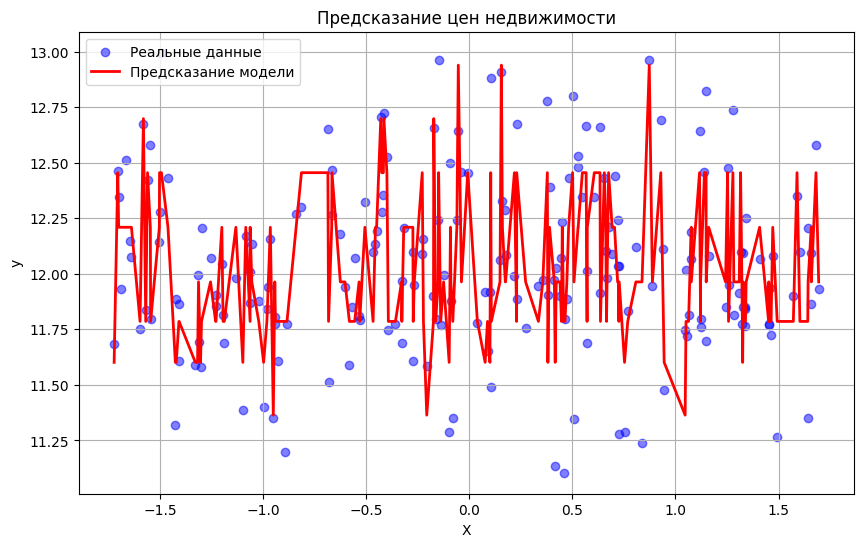

In [ ]:
test_loss = mse(y_test, y_pred)
print(f"Test MSE: {test_loss:.4f}")

sorted_indices = np.argsort(X_test_scaled[:, 0])

plt.figure(figsize=(10, 6))
plt.scatter(X_test_scaled[sorted_indices], y_test[sorted_indices], color='blue', alpha=0.5, label='Реальные данные')
plt.plot(X_test_scaled[sorted_indices], y_pred[sorted_indices], color='red', linewidth=2, label='Предсказание модели')
plt.title('Предсказание цен недвижимости')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()